In [1]:
!pip3 install transformers[pytorch]

     |████████████████████████████████| 3.4 MB 9.2 MB/s            
     |████████████████████████████████| 67 kB 354 kB/s             
     |████████████████████████████████| 895 kB 86.5 MB/s            
     |████████████████████████████████| 3.3 MB 65.7 MB/s            


In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.optim.lr_scheduler import StepLR
from transformers import GPT2TokenizerFast, GPT2Model, GPT2LMHeadModel
import random
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

zipurl = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('data')
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# !pip install transformers[torch]

In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# model = GPT2Model.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [6]:
gpt = GPT2LMHeadModel.from_pretrained('gpt2')

def score(tokens_tensor):
    loss=gpt(tokens_tensor, labels=tokens_tensor)[0]
    return torch.exp(loss)

texts = ['i would like to thank you mr chairman', 
         'i would liking to thanks you mr chair in',
         'thnks chair', 'me not know english']
for text in texts:
    tokens_tensor = tokenizer.encode( text, add_special_tokens=False, return_tensors="pt")
    # print(tokens_tensor)           
    print(text, score(tokens_tensor))

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

i would like to thank you mr chairman tensor(122.3064, grad_fn=<ExpBackward0>)
i would liking to thanks you mr chair in tensor(1183.7665, grad_fn=<ExpBackward0>)
thnks chair tensor(14135.1562, grad_fn=<ExpBackward0>)
me not know english tensor(1978.1694, grad_fn=<ExpBackward0>)


In [7]:
tokenizer(['I love you', 'You love me']).get('input_ids')

[[40, 1842, 345], [1639, 1842, 502]]

Inspiration: https://github.com/nyu-mll/CoLA-baselines

Build a module: https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_multiclass_classification.ipynb

Counting suprisal: https://www.researchgate.net/publication/343268482_Investigating_the_Role_of_Verb_Frequency_in_Factive_and_Manner-of-speaking_Islands

https://osf.io/98p2q/

In [235]:
from transformers import BertModel

class GPT2_acceptability(nn.Module):
   def __init__(self):
       super(GPT2_acceptability, self).__init__()
       self.model = GPT2Model.from_pretrained('gpt2')
       self.ln1 = nn.Linear(self.model.config.hidden_size, 384)
       self.ln2 = nn.Linear(384, 192)
       self.ln3 = nn.Linear(192, 30)
       self.ln4 = nn.Linear(30, 1)

   def forward(self, input_ids, attention_mask):
       with torch.no_grad():
        out = self.model(input_ids=input_ids,
                         attention_mask=attention_mask)
       out = out[0][:, 0, :]
      #  print(out)
       out = F.relu(self.ln1(out))
       out = F.relu(self.ln2(out))
       out = F.relu(self.ln3(out))
       return F.sigmoid(self.ln4(out))

In [236]:
# class GPT2_acceptability(nn.Module):
#    def __init__(self):
#        super(GPT2_acceptability, self).__init__()
#        self.model = GPT2LMHeadModel.from_pretrained('gpt2')
#        self.ln1 = nn.Linear(1, 20)
#        self.ln2 = nn.Linear(20, 50)
#        self.ln3 = nn.Linear(50, 20)
#        self.ln4 = nn.Linear(20, 1)

#    def forward(self, input_ids, attention_mask):
#        with torch.no_grad():
#         #  out=self.model(input_ids=input_ids, attention_mask=attention_mask)
#         out=self.model(input_ids=input_ids, 
#                        labels=input_ids,
#                        attention_mask=attention_mask)
#       #  print(out.logits.shape)
#        logits = out.logits 
#        print(logits.shape)
#        loss = torch.softmax(logits, dim=-1).prod(2)
       
#        out = torch.exp(loss.unsqueeze(0))
#        print(out)
#       #  out = torch.sum(out.hidden_states 
#       #                  * torch.log2(F.softmax(out.logits)), axis=1)
#        print(out.shape)
#        out = F.relu(self.ln1(out))
#        out = F.relu(self.ln2(out))
#        out = F.relu(self.ln3(out))
#        print(out.shape)
#        return F.sigmoid(self.ln4(out))

In [237]:
!cd data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [238]:
!ls data/cola_public/raw/in_domain_train.tsv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
data/cola_public/raw/in_domain_train.tsv


In [239]:
df = pd.read_csv('data/cola_public/raw/in_domain_train.tsv', sep='\t', names=['Grammaticality', 'Empty', 'Sentence'])
df
# df = pd.read_csv('in_domain_train.tsv', sep='\t')

,Grammaticality,Empty,Sentence
gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
gj04,1,NaN,One more pseudo generalization and I'm giving up.
gj04,1,NaN,One more pseudo generalization or I'm giving up.
gj04,1,NaN,"The more we study verbs, the crazier they get."
gj04,1,NaN,Day by day the facts are getting murkier.
...,...,...,...
ad03,0,*,Poseidon appears to own a dragon
ad03,0,*,Digitize is my happiest memory
ad03,1,NaN,It is easy to slay the Gorgon.
ad03,1,NaN,I had the strangest feeling that I knew you.


In [240]:
def encode(data, tokenizer):
    input_ids = []    
    attention_mask = []    
    for text in data:        
      tokenized_text = tokenizer.encode_plus(text,
                                            max_length=100,
                                            # add_special_tokens =True,
                                            pad_to_max_length=True,
                                            return_attention_mask=True)        
      input_ids.append(tokenized_text['input_ids'])        
      attention_mask.append(tokenized_text['attention_mask'])
    # print(tokenized_text)
    
    return torch.tensor(input_ids, dtype=torch.long), torch.tensor(attention_mask, dtype=torch.long)

In [241]:
texts = df.iloc[:,2].to_list()[0:6000]

In [242]:
ids, attention = encode(texts, tokenizer)

In [243]:
len(texts)

6000

In [244]:
ids.shape

torch.Size([6000, 100])

In [245]:
attention.shape

torch.Size([6000, 100])

In [246]:
labels = torch.from_numpy(df.iloc[:,0].to_numpy()[0:6000])
dataset = TensorDataset(ids, attention, labels) # create your datset
dataloader_train = DataLoader(dataset, batch_size=200, shuffle=True)

In [247]:
learning_rate = 1e-3
num_epochs = 20

model = GPT2_acceptability().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = nn.BCELoss()

In [248]:
ids[1]

tensor([ 3198,   517, 24543,  2276,  1634,   290,   314,  1101,  3501,   510,
           13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])

In [249]:
model(ids[1:100].to(device), attention[1:100].to(device))

tensor([[0.4959],
        [0.4959],
        [0.4952],
        [0.4988],
        [0.5055],
        [0.4934],
        [0.4943],
        [0.5009],
        [0.5054],
        [0.4952],
        [0.4952],
        [0.4943],
        [0.4952],
        [0.4952],
        [0.4943],
        [0.4943],
        [0.4968],
        [0.4968],
        [0.4952],
        [0.4952],
        [0.5009],
        [0.5009],
        [0.5009],
        [0.4933],
        [0.4933],
        [0.4933],
        [0.4943],
        [0.5009],
        [0.4934],
        [0.4938],
        [0.4943],
        [0.4943],
        [0.4943],
        [0.4952],
        [0.4943],
        [0.4943],
        [0.4927],
        [0.4968],
        [0.4968],
        [0.4968],
        [0.4968],
        [0.4968],
        [0.4968],
        [0.4952],
        [0.4952],
        [0.4952],
        [0.4952],
        [0.4952],
        [0.4952],
        [0.4952],
        [0.4943],
        [0.4952],
        [0.4943],
        [0.4952],
        [0.4952],
        [0

In [250]:
glob_loss = []

for epoch in range(num_epochs):
  correct = 0
  losses = []
  for ids, attention, y in dataloader_train:
    out = model(ids.to(device), attention.to(device))
    correct += torch.sum(torch.round(out).squeeze() == y.squeeze().to(device)).item()
    loss = loss_fn(out.squeeze(), y.to(torch.float32).squeeze().to(device))
    optimizer.zero_grad()
    loss.backward()
    losses.append(np.mean(loss.item()))
    optimizer.step()
    # scheduler.step()
  print(np.mean(losses))
  glob_loss.append(np.mean(losses))
  accuracy = correct / len(dataset)
  print("Accuracy = {}".format(accuracy))

0.6357235431671142
Accuracy = 0.68
0.6201017359892528
Accuracy = 0.6903333333333334
0.6196066836516062
Accuracy = 0.6903333333333334
0.6194096008936564
Accuracy = 0.6903333333333334
0.6196467200915019
Accuracy = 0.6903333333333334
0.6190704007943472
Accuracy = 0.6903333333333334
0.619253675142924
Accuracy = 0.6903333333333334
0.6187887748082479
Accuracy = 0.6903333333333334
0.618436727921168
Accuracy = 0.6903333333333334
0.6183704018592835
Accuracy = 0.6903333333333334
0.6182117819786072
Accuracy = 0.6903333333333334
0.617965829372406
Accuracy = 0.6903333333333334
0.6180114308993022
Accuracy = 0.6903333333333334
0.6181561827659607
Accuracy = 0.6903333333333334
0.6178217172622681
Accuracy = 0.6903333333333334
0.6175705075263977
Accuracy = 0.6903333333333334
0.617513773838679
Accuracy = 0.6903333333333334
0.6178864558537801
Accuracy = 0.6903333333333334
0.617133084932963
Accuracy = 0.6903333333333334
0.6172210852305094
Accuracy = 0.6903333333333334


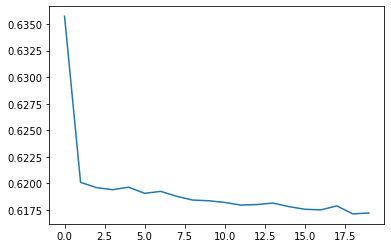

In [251]:
plt.plot(glob_loss)

In [256]:
texts_test = df.iloc[:,2].to_list()[6000:8000]
ids, attention = encode(texts_test, tokenizer)
labels = torch.from_numpy(df.iloc[:,0].to_numpy()[6000:8000])
dataset = TensorDataset(ids, attention, labels) # create your datset
dataloader_train = DataLoader(dataset, batch_size=200, shuffle=True)

In [ ]:
losses = []
correct = 0
for ids, attention, y in dataloader_train:
    out = model(ids.to(device), attention.to(device))
    correct += torch.sum(torch.round(out).squeeze() == y.squeeze().to(device))
    # print(out.shape)x
    loss = loss_fn(out.squeeze(), y.to(torch.float32).squeeze().to(device))
    losses.append(np.mean(loss.item()))
print(np.mean(losses))
print((correct / len(dataset)).item())